# Workflow part 3
---
Well, since we already have done all the previous steps We are able to perform a **spatial clustering** on our data. In case you don't know what is a **spatial clustering** this is a type of clustering method wich will consider the geographical information, i.e. lat and long data. To more information, please check this incredible book: 

**Geographic Data Science with Python**

**Authors**: REY, S. J.; ARRIBAS-BEL, D.; WOLF, L. J.

Source: https://geographicdata.science/book/intro.html

### In this part we will do four substeps:

- Spatial Contiguity Weights

- Spatial cluster (using Ward's method)

- Plot results
    
Most of this steps are entirely based on **pysal** package. So, check if you already has it installed.

In [31]:
import re
import scipy
import time
import sklearn
import numpy as np
import pandas as pd
import geopandas as gpd
import esda
import pysal as ps
import libpysal as lp
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import cluster
from sklearn.preprocessing import scale
import scipy.cluster.hierarchy as shc 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [32]:
outline = gpd.read_file(r'D:\Programming\UAV\dataset\area.shp')
shapefile = gpd.read_file(r'D:\Programming\UAV\dataset\Spatial_Join.shp')

# Looping on columns
print(shapefile.columns.tolist())

# Also, we will create another shapefile without geometry info
shp_data = shapefile.drop('geometry', axis=1)
shp_data.head()


['raster_val', 'vals_zscor', 'raster_v_1', 'vals_zsc_1', 'raster_v_2', 'vals_zsc_2', 'geometry']


raster_val  vals_zscor  raster_v_1  vals_zsc_1  raster_v_2  vals_zsc_2
0   -0.006224    1.564088    0.050466   -0.287209    0.037280   -0.267334
1   -0.006501    1.529497    0.043645   -0.832619    0.032248   -0.824462
2   -0.004860    1.734322    0.053358   -0.055958    0.039399   -0.032675
3   -0.010469    1.034323    0.036810   -1.379179    0.027270   -1.375526
4   -0.018871   -0.014259    0.030239   -1.904573    0.022448   -1.909353

## Creating Spatial Contiguity Weights

Here We will test 3 types of spatial weights: Queen, Rook and KNN. All implemented on pysal



In [33]:
# Queen
start = time.time()
wtq = lp.weights.Queen.from_dataframe(shapefile)
print('Queen',wtq.n)
print('elapsed time: ', time.time()-start)

# Rook
start = time.time()
wtr = lp.weights.Rook.from_dataframe(shapefile)
print('Rook',wtr.n)
print('elapsed time: ', time.time()-start)

# KNN - change the k neighborhoods
start = time.time()
wtk = lp.weights.KNN.from_dataframe(shapefile, k = 15) #, fixed=False )
print('KNN',wtk.n)
print('elapsed time: ', time.time()-start)

# Print info
print('Queen',wtq.histogram)
print('Rook',wtr.histogram)
print('KNN',wtk.histogram)

Queen 4731
elapsed time:  0.5196533203125
Rook 4731
elapsed time:  0.259263277053833
KNN 4731
elapsed time:  2.7963156700134277
Queen [(2, 2), (3, 2), (4, 50), (5, 172), (6, 50), (7, 56), (8, 4399)]
Rook [(1, 2), (2, 58), (3, 216), (4, 4455)]
KNN [(15, 4731)]


In [36]:
linkage_type = 'ward'
connections = [wtq, wtr, wtk]
connections_names = ['wtq', 'wtr', 'wtk']
clusters = [2,3,4]

def spatial_cluster(shapefile, linkage_type, connection, n_clusters, connection_name):
    model = cluster.AgglomerativeClustering(linkage = linkage_type, 
                                            connectivity = connection.sparse, 
                                            n_clusters = n_clusters)
    model.fit(shapefile)
    name_col = linkage_type + str(n_clusters) + connection_name
    shapefile[name_col] = model.labels_
    
    return shapefile

for clust in tqdm(clusters):
    shp_data = spatial_cluster(shapefile=shp_data, linkage_type=linkage_type,
                    connection=connections[0], n_clusters=clust, 
                    connection_name=connections_names[0])
    shp_data = spatial_cluster(shapefile=shp_data, linkage_type=linkage_type,
                    connection=connections[1], n_clusters=clust, 
                    connection_name=connections_names[1])
    shp_data = spatial_cluster(shapefile=shp_data, linkage_type=linkage_type,
                    connection=connections[2], n_clusters=clust, 
                    connection_name=connections_names[2])

# Let's check output
shp_data.head()

# Adding geometry again
shp_data['geometry'] = shapefile['geometry']

100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


In [37]:
# Selecting columns which contains an specific pattern, which will be 'ward'
def match_text(text, string):
    text = re.search(text, string)
    return text

clust_columns = [col for col in shp_data.columns.to_list() if match_text("ward", col) != None]
clust_columns

['ward2wtq',
 'ward2wtr',
 'ward2wtk',
 'ward3wtq',
 'ward3wtr',
 'ward3wtk',
 'ward4wtq',
 'ward4wtr',
 'ward4wtk']

### Colormap

To have better-looking maps, we will customize a colormap. So, first chose a colormap from matplotlib and select a number of colors

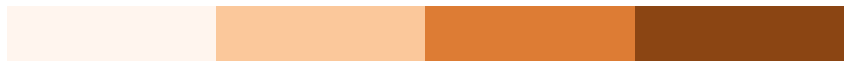

In [116]:
# Creating a colormap from specific colors
# To change number of segmented values change the N on cmap

colors = [ 'seashell', 'peachpuff', 'sandybrown', 'chocolate', 'saddlebrown']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(name="new cmap", colors = colors, N=np.max(clusters))
x, y = np.mgrid[1:2, 1:10:0.01]
plt.figure(figsize=[15, 1])
plt.imshow(y, cmap=cmap, aspect='auto')
plt.axis('off')
plt.show()

9it [00:09,  1.09s/it]


(2.0, 5.0, 2.0, 5.0)

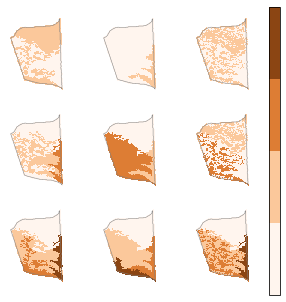

In [146]:
# Plotting our result
fig = plt.figure(figsize=(5,5))

for col, elem in tqdm( zip(clust_columns, range(1,len(clust_columns)+1)) ):
    ax = fig.add_subplot(3,3, elem)

    #ax.set_title(str(col)) # Subplot title:
    ax.axis('off')

    shp_data.sort_values(col).plot(column=col, ax=ax, categorical=True, 
                                    colormap= cmap, vmin=0, vmax=3,
                                    legend=False, label=col)
    outline.geometry.boundary.plot(color=None,edgecolor='grey',
                                    linewidth = 0.5, ax=ax)

# Plotting colorbar
scalar_map = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(clusters), vmax=np.max(clusters)+1))
scalar_map.set_array(clusters)

ax_cm = fig.add_axes([0.9, 0.1, 0.03, 0.8])
cbr = fig.colorbar(scalar_map, cax=ax_cm,
                    spacing='proportional', label=[1,2,3,4])

# Adjusting figure
plt.subplots_adjust(hspace=0.2, wspace=0)
plt.axis('off')

In [ ]:
# Saving 
data_info = 'Spatial_clustering'
name_output = f'../{linkage_type}_{data_info}_.png'
fig.savefig(name_output, dpi = 300, bbox_inches = 'tight')